<h1 style="text-align: center; font-size: 2.5rem; font-weight: bold; margin: 2.5rem 0 1rem;">Sentiment Analysis on Labeled Financial Data</h1>
<h2 style="text-align: center; font-size: 1rem; font-weight: 500; margin: 0 0 2rem;">Text Preprocessing and Sentiment Analysis</h2>

_____

<h2 style="text-align: center; font-size: 1rem; margin: 2rem 0 1rem 0;">Part II</h2>
<h1 style="text-align: center; font-size: 2rem; margin: 0 0 2rem 0;">Sentiment Analysis</h1>

<h2 style="padding: 0.5rem; background-color: #513d5c; color: white;">Imports</h2>

In [17]:
# Imports
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import nltk
import torch
from wordcloud import WordCloud, STOPWORDS
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score, classification_report
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from transformers import pipeline

In [2]:
## nltk - Dependencies
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\KubangPawis\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [3]:
raw_df = pd.read_csv('../data/raw/financial-data.csv')
clean_df = pd.read_csv('../data/clean/financial-data-clean.csv')

In [4]:
raw_df.head()

,Sentence,Sentiment
0,The GeoSolutions technology will leverage Bene...,positive
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative
2,"For the last quarter of 2010 , Componenta 's n...",positive
3,According to the Finnish-Russian Chamber of Co...,neutral
4,The Swedish buyout firm has sold its remaining...,neutral


In [5]:
clean_df.head()

,Sentence,Sentiment
0,geosolut technolog leverag benefon gp solut pr...,positive
1,esi low 150 250 bk real possibl,negative
2,last quarter 2010 componenta net sale doubl eu...,positive
3,accord finnishrussian chamber commerc major co...,neutral
4,swedish buyout firm sold remain 224 percent st...,neutral


<h2 style="padding: 0.5rem; background-color: #513d5c; color: white;">Data Cleaning</h2>

In [6]:
clean_df = clean_df.dropna()

<h2 style="padding: 0.5rem; background-color: #513d5c; color: white;">Visualizing Word Frequency - Word Cloud</h2>

In [7]:
all_text = " ".join(raw_df["Sentence"].astype(str).tolist())

wc = WordCloud(
    width=800, height=400,
    background_color="white",
    stopwords=STOPWORDS,
    max_words=200
).generate(all_text)

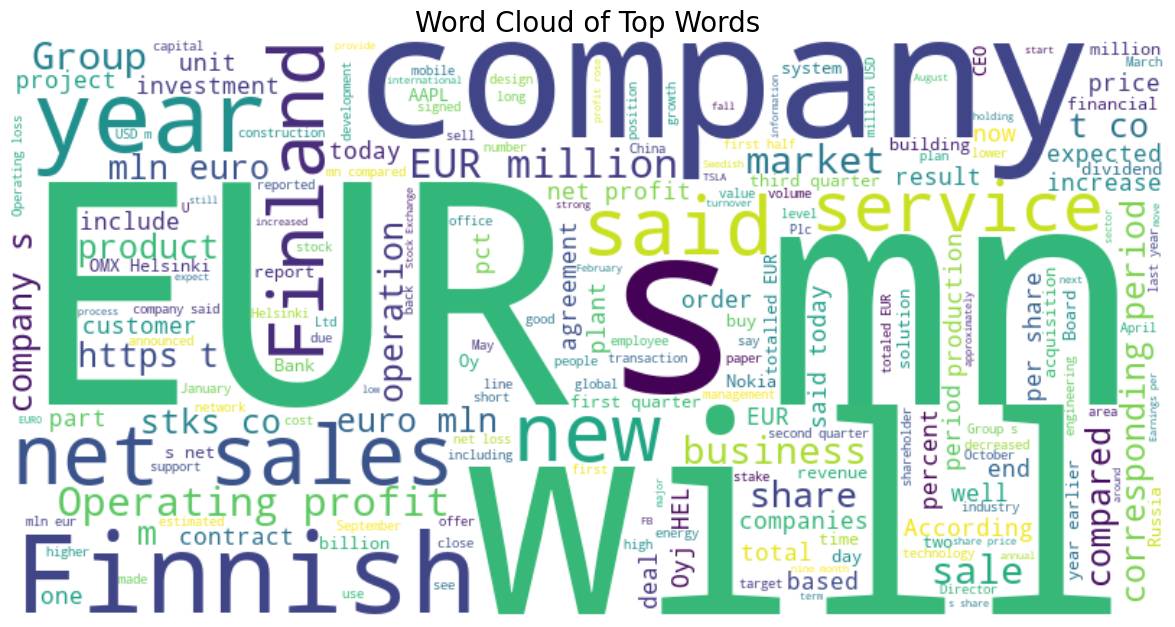

In [8]:
plt.figure(figsize=(15, 7.5))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud of Top Words", fontsize=20)
plt.show()

<h2 style="padding: 0.5rem; background-color: #513d5c; color: white;">Data Split</h2>

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    clean_df["Sentence"], clean_df["Sentiment"],
    test_size=0.2, random_state=2, stratify=clean_df["Sentiment"]
)

<h2 style="padding: 0.5rem; background-color: #513d5c; color: white;">Model Building</h2>

<div style="width: 30%;">
    <h3 style="background-color: #a07fb3; color: white; padding: 0.5rem 0.5rem; text-align: center; vertical-align: middle; box-shadow: 5px 5px #4d3e66;">1. Logistic Regression</h3>
    <div style="margin: 1.5rem 0;"></div>
</div>

In [10]:
vectorizer = TfidfVectorizer(max_features=10_000, ngram_range=(1,2), stop_words="english")
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf  = vectorizer.transform(X_test)

lr = LogisticRegression(max_iter=1_000)
lr.fit(X_train_tfidf, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


<div style="width: 30%;">
    <h3 style="background-color: #a07fb3; color: white; padding: 0.5rem 0.5rem; text-align: center; vertical-align: middle; box-shadow: 5px 5px #4d3e66;">2. VADER</h3>
    <div style="margin: 1.5rem 0;"></div>
</div>

In [13]:
vader = SentimentIntensityAnalyzer()
def vader_predict(texts):
    labels, scores = [], []
    for t in texts:
        c = vader.polarity_scores(t)["compound"]
        labels.append(1 if c >= 0 else 0)
        scores.append((c + 1) / 2)
    return labels, scores

<div style="width: 30%;">
    <h3 style="background-color: #a07fb3; color: white; padding: 0.5rem 0.5rem; text-align: center; vertical-align: middle; box-shadow: 5px 5px #4d3e66;">3. ROBERTa</h3>
    <div style="margin: 1.5rem 0;"></div>
</div>

In [14]:
roberta = pipeline(
    "sentiment-analysis",
    model="cardiffnlp/twitter-roberta-base-sentiment",
    tokenizer="cardiffnlp/twitter-roberta-base-sentiment",
    return_all_scores=False
)
def roberta_predict(texts):
    preds = roberta(texts, truncation=True)
    labels, scores = [], []
    for p in preds:
        lbl = 1 if p["label"] == "LABEL_2" else 0
        labels.append(lbl)
        if p["label"] == "LABEL_1":
            scores.append(0.5)
        else:
            scores.append(p["score"] if lbl == 1 else 1 - p["score"])
    return labels, scores

Device set to use cpu


<h2 style="padding: 0.5rem; background-color: #513d5c; color: white;">Model Inference</h2>

In [15]:
results = []

# Logistic Regression
y_pred_lr = lr.predict(X_test_tfidf)
y_prob_lr = lr.predict_proba(X_test_tfidf)[:,1]
results.append(("LogisticRegression", y_pred_lr, y_prob_lr))

# VADER
y_pred_v, y_prob_v = vader_predict(X_test.tolist())
results.append(("VADER", y_pred_v, y_prob_v))

# RoBERTa
y_pred_r, y_prob_r = roberta_predict(X_test.tolist())
results.append(("RoBERTa", y_pred_r, y_prob_r))

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


<h2 style="padding: 0.5rem; background-color: #513d5c; color: white;">Model Evaluation</h2>

In [38]:
int2str = {0: "negative", 1: "neutral", 2: "positive"}

if isinstance(y_test.iloc[0], int):
    y_test_labels = [int2str[i] for i in y_test]
else:
    y_test_labels = y_test.tolist()

def normalize_pred(p):
    return int2str[p] if isinstance(p, int) else p

y_pred_lr_labels = [normalize_pred(p) for p in y_pred_lr]
y_pred_v_labels  = [normalize_pred(p) for p in y_pred_v]
y_pred_r_labels  = [normalize_pred(p) for p in y_pred_r]

labels = ["negative", "neutral", "positive"]

<div style="width: 30%;">
    <h3 style="background-color: #a07fb3; color: white; padding: 0.5rem 0.5rem; text-align: center; vertical-align: middle; box-shadow: 5px 5px #4d3e66;">1. Logistic Regression</h3>
    <div style="margin: 1.5rem 0;"></div>
</div>

In [39]:
print("=== LogisticRegression ===")
print(classification_report(
    y_test_labels,
    y_pred_lr_labels,
    labels=labels
))

=== LogisticRegression ===
              precision    recall  f1-score   support

    negative       0.41      0.19      0.25       172
     neutral       0.68      0.86      0.76       626
    positive       0.78      0.62      0.69       371

    accuracy                           0.69      1169
   macro avg       0.62      0.56      0.57      1169
weighted avg       0.67      0.69      0.66      1169



**Logistic Regression**

* Overall accuracy: 0.69

* Struggles most with the negative class (F1 = 0.25): low recall (0.19) means many negatives are misclassified as neutral or positive. Precision (0.41) is moderate, so when it does call something negative it’s correct under half the time.

* Excels at neutral detection (F1 = 0.76): high recall (0.86) ensures most neutrals are captured, and precision (0.68) means false positives are limited.

* Positive performance is solid (F1 = 0.69): precision 0.78 indicates few false positives, but recall 0.62 shows some positives slip through.

* Macro‑avg F1 = 0.57 vs. weighted‑avg F1 = 0.66 reflects class imbalance (more neutrals).

**Interpretation**: Logistic Regression with TF‑IDF provides the best balanced performance. However, its negative‐class recall is very low—suggesting a need for class‐weight adjustment, oversampling of negative examples, or feature engineering to better capture negative sentiment signals.

<div style="width: 30%;">
    <h3 style="background-color: #a07fb3; color: white; padding: 0.5rem 0.5rem; text-align: center; vertical-align: middle; box-shadow: 5px 5px #4d3e66;">2. VADER</h3>
    <div style="margin: 1.5rem 0;"></div>
</div>

In [41]:
print("\n=== VADER ===")
print(classification_report(
    y_test_labels,
    y_pred_v_labels,
    labels=labels
))


=== VADER ===
              precision    recall  f1-score   support

    negative       0.37      0.30      0.33       172
     neutral       0.55      0.90      0.68       626
    positive       0.00      0.00      0.00       371

    accuracy                           0.53      1169
   macro avg       0.31      0.40      0.34      1169
weighted avg       0.35      0.53      0.41      1169



C:\Users\KubangPawis\Jupyter\sentiment-analysis-prac-1\venv\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\KubangPawis\Jupyter\sentiment-analysis-prac-1\venv\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\KubangPawis\Jupyter\sentiment-analysis-prac-1\venv\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


**VADER**

* Overall accuracy: 0.53

* Neutral class is its strong suit (F1 = 0.68, recall = 0.90), thanks to rule‑based heuristics catching “neutral” language well.

* Negative class: F1 = 0.33 (precision = 0.37, recall = 0.30) — modest at best.

* Positive class completely fails (F1 = 0.00): VADER never predicts “positive” (or thresholding maps all positives to non‑positive).

**Interpretation**: While VADER is fast and unsupervised, its thresholds or lexicon aren’t tuned for your data, leading to zero positive detections. You could try adjusting the compound‐score threshold or augmenting the lexicon, but rule‑based methods often struggle with nuanced, domain‑specific language.



<div style="width: 30%;">
    <h3 style="background-color: #a07fb3; color: white; padding: 0.5rem 0.5rem; text-align: center; vertical-align: middle; box-shadow: 5px 5px #4d3e66;">3. ROBERTa</h3>
    <div style="margin: 1.5rem 0;"></div>
</div>

In [42]:
print("\n=== RoBERTa ===")
print(classification_report(
    y_test_labels,
    y_pred_r_labels,
    labels=labels
))


=== RoBERTa ===
              precision    recall  f1-score   support

    negative       0.15      0.99      0.26       172
     neutral       0.19      0.01      0.02       626
    positive       0.00      0.00      0.00       371

    accuracy                           0.15      1169
   macro avg       0.11      0.33      0.09      1169
weighted avg       0.12      0.15      0.05      1169



C:\Users\KubangPawis\Jupyter\sentiment-analysis-prac-1\venv\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\KubangPawis\Jupyter\sentiment-analysis-prac-1\venv\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\KubangPawis\Jupyter\sentiment-analysis-prac-1\venv\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


**RoBERTa (twitter‑roberta‑base‑sentiment)**

* Overall accuracy: 0.15
* Almost every example is tagged negative (recall = 0.99, but precision = 0.15), while neutral and positive are virtually never detected (F1 ≈ 0).

**Interpretation**: The off‑the‑shelf RoBERTa checkpoint is severely misaligned with your dataset: its decision boundaries collapse almost everything into “negative.” This suggests you need to fine‑tune on your labeled data (rather than zero‑shot usage), or choose a checkpoint pre‑trained on more similar text.

<h2 style="padding: 0.5rem; background-color: #513d5c; color: white;">Decision - Best Model</h2>

* Best performer: Logistic Regression by a wide margin (accuracy 0.69 vs. 0.53/0.15).

* Rule‑based vs. learned: VADER outperforms RoBERTa zero‑shot but still lags behind a simple TF‑IDF + LR model.

* Error patterns:
    * Both VADER and RoBERTa under‑predict positives; LR’s higher positive recall (0.62) makes it preferable when detecting positive sentiment matters.
    * All three struggle most with the minority negative class; class imbalance needs addressing.

<h2 style="padding: 0.5rem; background-color: #513d5c; color: white;">Reflection - Practicality of Sentiment Analysis</h2>

Working on sentiment analysis for financial text has taught me that raw accuracy often hides critical blind spots—like treating a tweet saying “the stock is sinking” as neutral—that can be the difference between a good model and a useful one. I’ve learned to tailor lexicons to finance jargon, fine‑tune transformers on domain‑specific data, and view sentiment not as a standalone prediction but as one signal among many in market analysis. Each incremental gain in recall or precision feels less like a technical win and more like a deeper understanding of how language actually moves stock prices.